In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import trange

import torch
import torch.nn as nn

torch.__version__

'1.7.0+cu101'

In [2]:
def sample_targets(size=1):
    where = np.random.rand(size) > 0.7
    a = np.random.normal(-3, 0.5, size)
    b = np.random.normal( 3, 0.5, size)
    return torch.Tensor(np.where(where, a, b).reshape(size, 1))

def sample_normal(size=1):
    return torch.normal(0, 1, (size, 1))

(torch.Size([1000, 1]), torch.Size([1000, 1]))

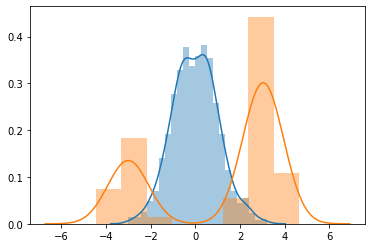

In [3]:
X = sample_normal(1000)
Y = sample_targets(1000)

sns.distplot(X)
sns.distplot(Y)

X.shape, Y.shape

In [4]:
def dense(inp, out, a=nn.Tanh):
    return [
        nn.Linear(inp, out),
        a(),
    ]

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            *dense(1 , 20),
            *dense(20, 20),
            *dense(20,  1, nn.Identity),
        )
        
    def map_batch(self, x):
        return self.net(x)
        
    def forward(self, bs):
        noise = sample_normal(bs)
        return self.net(noise)
    
mk_G = lambda: Generator()

In [6]:
mk_D = lambda: nn.Sequential(
    *dense(1 , 20),
#     *dense(20, 20),
    *dense(20,  1, nn.Sigmoid),
)

In [7]:
D = mk_D()
G = mk_G()

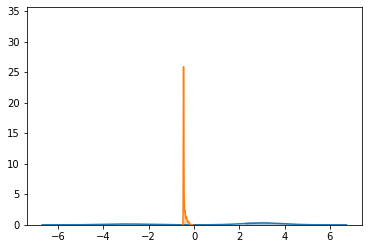

In [8]:
Y = sample_targets(1000)
GY = G(1000).detach().numpy()

sns.distplot(Y)
sns.distplot(GY)

In [9]:
g = G(10)
d = D(g)
t = D(sample_targets(10))
g.shape, d.shape, t.shape

(torch.Size([10, 1]), torch.Size([10, 1]), torch.Size([10, 1]))

In [10]:
def optimize(G, D, data_sampler, its, bs, lr, on_it=lambda _: None):
    criterion = nn.BCELoss()

    g_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
    d_optimizer = torch.optim.Adam(D.parameters(), lr=lr)

    def optimize_G():
        g_optimizer.zero_grad()
        loss = criterion(D(G(bs)), torch.ones(bs, 1))
        loss.backward()
        g_optimizer.step()

        return loss.item()

    def optimize_D():
        d_optimizer.zero_grad()
        real_loss = criterion(D(data_sampler(bs)), torch.ones(bs, 1))
        fake_loss = criterion(D(G(bs)), torch.zeros(bs, 1))
        real_loss.backward()
        fake_loss.backward()
        d_optimizer.step()

        return real_loss.item() + fake_loss.item()

    tri = trange(its)
    for i in tri:
        d_loss = optimize_D()
        g_loss = optimize_G()

        tri.set_description('G Loss:%.5f / D Loss:%.5f' % (g_loss, d_loss))
        on_it(i)

In [11]:
D = mk_D()
G = mk_G()

optimize(
    G=G,
    D=D,
    data_sampler=sample_targets,
    its=100,
    bs=512,
    lr=0.001
)

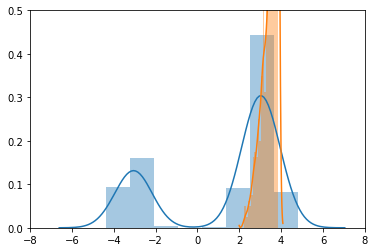

In [12]:
Y = sample_targets(1000)
GY = G(1000).detach().numpy()


fig, ax = plt.subplots()
sns.distplot(Y, ax=ax)
sns.distplot(GY, ax=ax)

ax.set_xbound(-8, 8)
ax.set_ybound(0, 0.5)

fig.canvas.draw()

In [13]:
Y = sample_targets(1000)
X = sample_normal(1000)

def render_frame():
    GY = G.map_batch(X).detach().numpy()

    fig, ax = plt.subplots()
    sns.distplot(Y, ax=ax)
    sns.distplot(GY, ax=ax)

    ax.set_xbound(-8, 8)
    ax.set_ybound(0, 0.5)

    fig.canvas.draw()
    plt.close()

    return np.array(fig.canvas.renderer.buffer_rgba())[:,:,:3].astype(np.uint8)

In [14]:
frame = render_frame()
W, H = frame.shape[:2]

frame.shape

(288, 432, 3)

In [15]:
D = mk_D()
G = mk_G()

In [16]:
import cv2

name = './distribs3.webm'

fourcc = cv2.VideoWriter_fourcc(*'VP80')
video = cv2.VideoWriter(name, fourcc, 30, (H, W))

def make_video_frame(i):
    if i % 10 == 0:
        frame = render_frame()
        video.write(frame)

In [17]:
optimize(
    G=G,
    D=D,
    data_sampler=sample_targets,
    its=2000,
    bs=512,
    lr=0.001,
    on_it=make_video_frame
)

In [18]:
video.release()

In [19]:
from IPython.display import HTML

HTML("""
    <video alt="test" controls>
        <source src="distribs3.webm" type="video/mp4">
    </video>
""")